In [1]:
!mamba install geopandas
import geopandas as gpd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from shapely.geometry import box

mambajs 0.19.13

Specs: xeus-python, numpy, matplotlib, pillow, ipywidgets>=8.1.6, ipyleaflet, scipy, geopandas
Channels: emscripten-forge, conda-forge

Solving environment...
Solving took 1.6873999999761582 seconds
  Name                          Version                       Build                         Channel                       
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
+ brotli-python                 1.2.0                         py313h33caa6c_0               emscripten-forge              
+ certifi                       2026.1.4                      pyhd8ed1ab_0                  conda-forge                   
+ charset-normalizer            3.4.4                         pyhd8ed1ab_0                  conda-forge                   
+ folium                        0.20.0                        pyhd8ed1ab_0                  conda-forge                   
+ geopandas                     1.1.2           

Text(125.84722222222221, 0.5, 'Y')

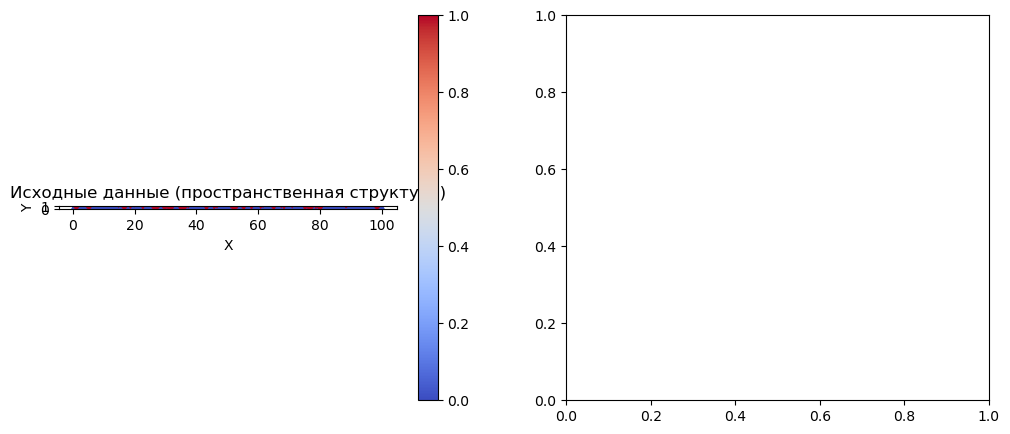

In [12]:
# Создаём синтетические данные с пространственной структурой
np.random.seed(42)
n_samples = 1000

# Координаты
x = np.random.uniform(0, 100, n_samples)
y = np.random.uniform(0, 100, n_samples)

# Целевая переменная с пространственной автокорреляцией
# Чем ближе к центру (50,50), тем выше вероятность класса 1
center_dist = np.sqrt((x - 50)**2 + (y - 50)**2)
prob_class1 = 1 / (1 + np.exp((center_dist - 30) / 10))  # логистическая функция
y = (np.random.random(n_samples) < prob_class1).astype(int)

# Признаки с шумом
X = np.column_stack([x, y, np.random.randn(n_samples, 3)])

# Создаём GeoDataFrame
gdf = gpd.GeoDataFrame({
    'x': x, 'y': y, 'target': y,
    'feature1': X[:, 2], 'feature2': X[:, 3], 'feature3': X[:, 4]
}, geometry=gpd.points_from_xy(x, y))

# Визуализация пространственной структуры
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

gdf.plot(column='target', ax=ax1, markersize=10, cmap='coolwarm', legend=True)
ax1.set_title('Исходные данные (пространственная структура)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')


In [5]:
# 1. Случайная кросс-валидация
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores_random = []

for train_idx, test_idx in kf.split(X):
    rf = RandomForestClassifier(n_estimators=50, random_state=42)
    rf.fit(X[train_idx], y[train_idx])
    y_pred = rf.predict(X[test_idx])
    scores_random.append(accuracy_score(y[test_idx], y_pred))

print(f"Случайная CV: accuracy = {np.mean(scores_random):.3f} ± {np.std(scores_random):.3f}")

# 2. Блочная кросс-валидация (по пространственным блокам)
# Делим область на 4 блока
blocks = []
for i in range(2):
    for j in range(2):
        blocks.append(box(i*50, j*50, (i+1)*50, (j+1)*50))

# Визуализация блоков
for block in blocks:
    ax2.add_patch(plt.Rectangle((block.bounds[0], block.bounds[1]), 
                                 50, 50, fill=None, edgecolor='red', linewidth=2))
gdf.plot(ax=ax2, color='blue', markersize=5, alpha=0.5)
ax2.set_title('Пространственные блоки для CV')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_xlim(0, 100)
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

# Блочная CV
scores_spatial = []

for block in blocks:
    # Тест = точки внутри блока
    test_mask = gdf.within(block)
    train_mask = ~test_mask
    
    if sum(test_mask) > 0 and sum(train_mask) > 0:
        rf = RandomForestClassifier(n_estimators=50, random_state=42)
        rf.fit(X[train_mask], y[train_mask])
        y_pred = rf.predict(X[test_mask])
        scores_spatial.append(accuracy_score(y[test_mask], y_pred))

print(f"Блочная CV: accuracy = {np.mean(scores_spatial):.3f} ± {np.std(scores_spatial):.3f}")

# Сравнение
print("\n=== Сравнение ===")
print(f"Разница в accuracy: {np.mean(scores_random) - np.mean(scores_spatial):.3f}")
print(f"Разница в std: {np.std(scores_spatial) - np.std(scores_random):.3f}")

Случайная CV: accuracy = 1.000 ± 0.000


<Figure size 640x480 with 0 Axes>

Блочная CV: accuracy = 1.000 ± 0.000

=== Сравнение ===
Разница в accuracy: 0.000
Разница в std: 0.000
